In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir(os.path.dirname("../"))

In [3]:
import cv2
import deepof.data
import deepof.models
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import tqdm.notebook as tqdm

from ipywidgets import interact

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
import umap

# Retrieve phenotypes

In [6]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [7]:
# Load first batch
dset11 = pd.ExcelFile(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_1/DLC_single_CDR1_1/1.Openfield_data-part1/JB05.1-OF-SI-part1.xlsx"
)
dset12 = pd.ExcelFile(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_1/DLC_single_CDR1_1/2.Openfielddata-part2/AnimalID's-JB05.1-part2.xlsx"
)
dset11 = pd.read_excel(dset11, "Tabelle2")
dset12 = pd.read_excel(dset12, "Tabelle2")

dset11.Test = dset11.Test.apply(lambda x: "Test {}_s11".format(x))
dset12.Test = dset12.Test.apply(lambda x: "Test {}_s12".format(x))

dset1 = {"CSDS":list(dset11.loc[dset11.Treatment.isin(["CTR+CSDS","NatCre+CSDS"]), "Test"]) + 
                list(dset12.loc[dset12.Treatment.isin(["CTR+CSDS","NatCre+CSDS"]), "Test"]),
         "NS":  list(dset11.loc[dset11.Treatment.isin(["CTR+nonstressed","NatCre+nonstressed"]), "Test"]) + 
                list(dset12.loc[dset12.Treatment.isin(["CTR+nonstressed","NatCre+nonstressed"]), "Test"]),}

dset1inv = {}
for i in flatten(list(dset1.values())):
    if i in dset1["CSDS"]:
        dset1inv[i] = "CSDS"
    else:
        dset1inv[i] = "NS"
        
assert len(dset1inv) == dset11.shape[0] + dset12.shape[0], "You missed some labels!"

In [8]:
# Load second batch
dset21 = pd.read_excel(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_2/Part1/2_Single/stressproject22.04.2020genotypes-openfieldday1.xlsx"
)
dset22 = pd.read_excel(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_2/Part2/2_Single/OpenFieldvideos-part2.xlsx"
)
dset21.Test = dset21.Test.apply(lambda x: "Test {}_s21".format(x))
dset22.Test = dset22.Test.apply(lambda x: "Test {}_s22".format(x))

dset2 = {"CSDS":list(dset21.loc[dset21.Treatment == "Stress", "Test"]) + 
                list(dset22.loc[dset22.Treatment == "Stressed", "Test"]),
         "NS":  list(dset21.loc[dset21.Treatment == "Nonstressed", "Test"]) +
                list(dset22.loc[dset22.Treatment == "Nonstressed", "Test"])}

dset2inv = {}
for i in flatten(list(dset2.values())):
    if i in dset2["CSDS"]:
        dset2inv[i] = "CSDS"
    else:
        dset2inv[i] = "NS"
        
assert len(dset2inv) == dset21.shape[0] + dset22.shape[0], "You missed some labels!"

In [9]:
# Load third batch

dset31 = pd.read_excel(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_3/1.Day2OF-SIpart1/JB05 2Female-ELS-OF-SIpart1.xlsx",
    sheet_name=1
)
dset32 = pd.read_excel(
    "../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_3/2.Day3OF-SIpart2/JB05 2FEMALE-ELS-OF-SIpart2.xlsx",
    sheet_name=1
)
dset31.Test = dset31.Test.apply(lambda x: "Test {}_s31".format(x))
dset32.Test = dset32.Test.apply(lambda x: "Test {}_s32".format(x))

dset3 = {"CSDS":[],
         "NS":  list(dset31.loc[:, "Test"]) +
                list(dset32.loc[:, "Test"])}

dset3inv = {}
for i in flatten(list(dset3.values())):
    if i in dset3["CSDS"]:
        dset3inv[i] = "CSDS"
    else:
        dset3inv[i] = "NS"
        
assert len(dset3inv) == dset31.shape[0] + dset32.shape[0], "You missed some labels!"

In [10]:
# Load fourth batch
dset41 = os.listdir("../../Desktop/deepof-data/tagged_videos/Individual_datasets/DLC_batch_4/JB05.4-OpenFieldvideos/")

# Remove empty video!
dset41 = [vid for vid in dset41 if "52" not in vid]

dset4 = {"CSDS":[],
         "NS":  [i[:-4]+"_s41" for i in dset41]}

dset4inv = {}
for i in flatten(list(dset4.values())):
    if i in dset4["CSDS"]:
        dset4inv[i] = "CSDS"
    else:
        dset4inv[i] = "NS"
        
assert len(dset4inv) == len(dset41), "You missed some labels!"

In [11]:
# Merge phenotype dicts and serialise!
aggregated_dset = {**dset1inv, **dset2inv, **dset3inv, **dset4inv}

In [12]:
from collections import Counter
print(Counter(aggregated_dset.values()))
print(115+52)

Counter({'NS': 115, 'CSDS': 52})
167


In [13]:
# Save aggregated dataset to disk
import pickle
with open("../../Desktop/deepof-data/deepof_single_topview/deepof_exp_conditions.pkl", "wb") as handle:
    pickle.dump(aggregated_dset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Define and run project

In [16]:
%%time
deepof_main = deepof.data.project(path=os.path.join("..","..","Desktop","deepoftesttemp"),
                                  smooth_alpha=0.99,                                     
                                  arena_dims=[380],
                                  exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip", "Tail_base"],
                                  exp_conditions=aggregated_dset
                                 )

CPU times: user 111 ms, sys: 14 ms, total: 125 ms
Wall time: 123 ms


In [17]:
%%time
deepof_main = deepof_main.run(verbose=True)
print(deepof_main)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!
Coordinates of 2 videos across 2 conditions
CPU times: user 4.8 s, sys: 806 ms, total: 5.61 s
Wall time: 4.32 s


In [18]:
all_quality = pd.concat([tab for tab in deepof_main.get_quality().values()])

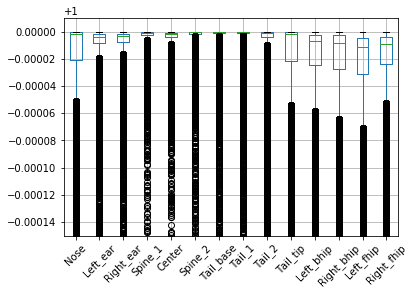

In [19]:
all_quality.boxplot(rot=45)
plt.ylim(0.99985, 1.00001)
plt.show()

In [20]:
@interact(quality_top=(0., 1., 0.01))
def low_quality_tags(quality_top):
    pd.DataFrame(pd.melt(all_quality).groupby("bodyparts").value.apply(
        lambda y: sum(y<quality_top) / len(y) * 100)
                ).sort_values(by="value", ascending=False).plot.bar(rot=45)
    
    plt.xlabel("body part")
    plt.ylabel("Tags with quality under {} (%)".format(quality_top * 100))
    plt.tight_layout()
    plt.legend([])
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='quality_top', max=1.0, step=0.01), Output()), _dom_c…

# Generate coords

In [47]:
%%time
deepof_coords = deepof_main.get_coords(center="Center", polar=False, speed=0, align="Spine_1", align_inplace=True, propagate_labels=False)
#deepof_dists  = deepof_main.get_distances(propagate_labels=False)
#deepof_angles = deepof_main.get_angles(propagate_labels=False)

CPU times: user 624 ms, sys: 27 ms, total: 651 ms
Wall time: 662 ms


# Visualization

In [352]:
%%time

tf.keras.backend.clear_session()

print("Preprocessing training set...")
deepof_train = deepof_coords.preprocess(
    window_size=24,
    window_step=24,
    conv_filter=None,
    scale="standard",
    shuffle=False,
    test_videos=0,
)[0]

# print("Loading pre-trained model...")
# encoder, decoder, grouper, gmvaep, = deepof.models.SEQ_2_SEQ_GMVAE(
#     loss="ELBO",
#     number_of_components=20,
#     compile_model=True,
#     kl_warmup_epochs=20,
#     montecarlo_kl=10,
#     encoding=6,
#     mmd_warmup_epochs=20,
#     predictor=0,
#     phenotype_prediction=0,
# ).build(deepof_train.shape)[:4]

Preprocessing training set...
CPU times: user 18.1 ms, sys: 13 ms, total: 31.1 ms
Wall time: 37.4 ms


In [353]:
weights = ["./latreg_trained_weights/"+i for i in os.listdir("./latreg_trained_weights/") if "encoding=8" in i]
weights

['./latreg_trained_weights/GMVAE_loss=ELBO_encoding=8_k=25_latreg=none_20210212-021944_final_weights.h5',
 './latreg_trained_weights/GMVAE_loss=ELBO_encoding=8_k=25_latreg=categorical_20210212-031749_final_weights.h5',
 './latreg_trained_weights/GMVAE_loss=ELBO_encoding=8_k=25_latreg=categorical+variance_20210212-022008_final_weights.h5',
 './latreg_trained_weights/GMVAE_loss=ELBO_encoding=8_k=25_latreg=variance_20210212-023839_final_weights.h5']

In [316]:
trained_network = weights[2]
print(trained_network)
l = int(re.findall("encoding=(\d+)_", trained_network)[0])
k = int(re.findall("k=(\d+)_", trained_network)[0])
pheno = 0

encoder, decoder, grouper, gmvaep, = deepof.models.SEQ_2_SEQ_GMVAE(
    loss="ELBO",
    number_of_components=k,
    compile_model=True,
    kl_warmup_epochs=20,
    montecarlo_kl=10,
    encoding=l,
    mmd_warmup_epochs=20,
    predictor=0,
    phenotype_prediction=pheno,
    reg_cat_clusters=("categorical" in trained_network),
    reg_cluster_variance=("variance" in trained_network),
).build(deepof_train.shape)[:4]

gmvaep.load_weights(trained_network)

./latreg_trained_weights/GMVAE_loss=ELBO_encoding=8_k=25_latreg=categorical+variance_20210212-022008_final_weights.h5


In [317]:
# Get data to pass through the models
trained_distribution = encoder(deepof_train)
categories = tf.keras.models.Model(encoder.input, encoder.layers[15].output)(deepof_train).numpy()

# Fit a scaler to unscale the reconstructions later on
video_key = np.random.choice(list(deepof_coords.keys()), 1)[0]
scaler = StandardScaler()
scaler.fit(np.array(pd.concat(list(deepof_coords.values()))))

StandardScaler()

In [318]:
# Retrieve latent distribution parameters and sample from posterior
def get_median_params(component, categories, cluster, param):
    # means = [np.median(component.mean().numpy(), axis=0) for component in mix_components]
    # stddevs = [np.median(component.stddev().numpy(), axis=0) for component in mix_components]
    if param == "mean":
        component = component.mean().numpy()
    elif param == "stddev":
        component = component.stddev().numpy()
    
    cluster_select = np.argmax(categories, axis=1)==cluster
    if np.sum(cluster_select) == 0:
        return None
    component = component[cluster_select]
    return np.median(component, axis=0)

In [329]:
def retrieve_latent_parameters(distribution, reduce=False, plot=False, categories=None, filt=0, save=True):
    mix_components = distribution.components
    
    # The main problem is here! We need to select only those training instances in which a given cluster was selected. 
    # Then compute the median for those only
    
    means = [get_median_params(component, categories, i, "mean") for i,component in enumerate(mix_components)]
    stddevs = [get_median_params(component, categories, i, "stddev") for i,component in enumerate(mix_components)]
    means = [i for i in means if i is not None]
    stddevs = [i for i in stddevs if i is not None]
    
    if filter:
        filts = np.max(categories, axis=0) > filt
        means = [i for i,j in zip(means, filts) if j]
        stddevs = [i for i,j in zip(stddevs, filts) if j]
    
    if reduce:
        data = [np.random.normal(size=[1000, len(means[0])],
                                 loc=meanvec, 
                                 scale=stddevvec)[:,np.newaxis] for meanvec, stddevvec in zip(means, stddevs)]
        data = np.concatenate(data, axis=1).reshape([1000*len(means), len(means[0])])        
        reducer = PCA(n_components=3)
        data = reducer.fit_transform(data)
        data = data.reshape([1000, len(means), 3])
        
    if plot == 2:
        for i in range(len(means)):
            plt.scatter(data[:,i,0], data[:,i,1], label=i)
        plt.title("Mean representation of latent space - K={}/{} - L={} - filt={}".format(len(means), 
                                                                                          len(mix_components), 
                                                                                          len(means[0]), filt))        
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        #plt.legend()
        if save:
            plt.savefig("Mean representation of latent space - K={}.{} - L={} - filt={}.png".format(len(means), 
                                                                                          len(mix_components), 
                                                                                          len(means[0]), filt).replace(" ", "_"))
        plt.show()
        
    elif plot == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in range(len(means)):
            ax.scatter(data[:,i,0], data[:,i,1], data[:,i,2], label=i)
        plt.title("Mean representation of latent space - K={}/{} - L={} - filt={}".format(len(means), 
                                                                                          len(mix_components), 
                                                                                          len(means[0]), filt))
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.set_zlabel("PCA 3")
        #plt.legend()
        if save:
            plt.savefig("Mean representation of latent space - K={}.{} - L={} - filt={}.png".format(len(means), 
                                                                                          len(mix_components), 
                                                                                          len(means[0]), filt).replace(" ", "_"))
        plt.show()
    
    elif plot > 3:
        raise ValueError("Can't plot in more than 3 dimensions!")
    
    return means, stddevs

def sample_from_posterior(decoder, parameters, component, enable_variance=False, video_output=False, samples=1):
    means, stddevs = parameters
    sample = np.random.normal(size=[samples, len(means[component])], loc=means[component], scale=(stddevs[component] if enable_variance else 0))
    reconstruction = decoder(sample).mean()
    
    if video_output:
        scaled_video_rec = scaler.inverse_transform(reconstruction)
        scaled_video_rec = scaled_video_rec.reshape(
            [samples*scaled_video_rec.shape[1], scaled_video_rec.shape[2]]
        )
        columns = deepof_coords[list(deepof_coords.keys())[0]].columns
        scaled_video_rec = pd.DataFrame(scaled_video_rec, columns=columns)

        ### VIDEO OUTPUT ###
        w = 400
        h = 400
        factor = 2.5

        # Instantiate video
        writer = cv2.VideoWriter()
        writer.open(
            "Reconstruction_test_L={}_k={}_pheno={}_component={}_video.avi".format(l,k,pheno,component),
            cv2.VideoWriter_fourcc(*"MJPG"),
            24,
            (int(w * factor), int(h * factor)),
            True,
        )

        for frame in tqdm.tqdm(range(scaled_video_rec.shape[0])):

            image = np.zeros((h, w, 3), np.uint8) + 30
            for bpart in scaled_video_rec.columns.levels[0]:

                try:
                    pos = (
                        (-int(scaled_video_rec[bpart].loc[frame, "x"]) + w // 2),
                        (-int(scaled_video_rec[bpart].loc[frame, "y"]) + h // 2),
                    )

                    cv2.circle(image, pos, 2, (0, 0, 255), -1)

                except KeyError:
                    continue

            # draw skeleton
            def draw_line(start, end, df, col):
                for bpart in end:
                    cv2.line(
                        image,
                        tuple(-df[start].loc[frame, :].astype(int) + w // 2),
                        tuple(-df[bpart].loc[frame, :].astype(int) + h // 2),
                        col,
                        1,
                    )

            col = (0,0,255)
            draw_line("Nose", ["Left_ear", "Right_ear"], scaled_video_rec, col)
            draw_line("Spine_1", ["Left_ear", "Right_ear", "Left_fhip", "Right_fhip"], scaled_video_rec, col)
            draw_line("Spine_2", ["Spine_1", "Left_bhip", "Right_bhip"], scaled_video_rec, col)
            #draw_line("Tail_1", ["Tail_base", "Tail_2"], scaled_video_rec, col)
            #draw_line("Tail_tip", ["Tail_2"], scaled_video_rec, col)

            image = cv2.resize(image, (0, 0), fx=factor, fy=factor)
            writer.write(image)

        writer.release()
        cv2.destroyAllWindows()
    
    return reconstruction


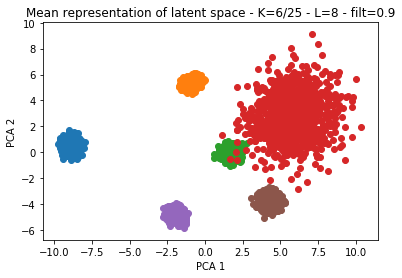

In [330]:
means, stddevs = retrieve_latent_parameters(trained_distribution, categories=categories, reduce=True, plot=2, filt=0.9, save=True)
#for i in range(0, 25):
#    reconst = sample_from_posterior(decoder, (means, stddevs), i, enable_variance=True, video_output=True, samples=5)

In [321]:
# Load rule based labels for the videos at play
tag_path = "./rule_based_labels/"
rule_based_tags = [tag_path+i for i in os.listdir(tag_path) for j in list(deepof_main._tables.keys()) if j in i]
rule_based_tags

['./rule_based_labels/Test 1_s12_rulebased_annot.tsv',
 './rule_based_labels/Test 1_s11_rulebased_annot.tsv']

In [346]:
tags = {k:pd.read_csv(k, sep="\t") for k in rule_based_tags}
concat_tags = np.concatenate(list(tags.values()))
concat_tags = concat_tags[:,3]
concat_tags.shape

(30002,)

In [400]:
moving = pd.Series(concat_tags).rolling(window=24, ).apply(lambda x: np.any(x > 2))[::24][1:].astype(bool)

In [401]:
moving

24        True
48        True
72        True
96        True
120       True
         ...  
29904    False
29928     True
29952     True
29976     True
30000     True
Length: 1250, dtype: bool

In [402]:
# Pass training set through the grouper to obtain cluster assignments
clusters = grouper.predict(deepof_train)
argmax_clusters = np.argmax(clusters, axis=1)
confid_clusters = np.max(clusters, axis=1)

In [403]:
for i in range(max(argmax_clusters)):
    if i in argmax_clusters[confid_clusters > 0.9]:
        print(i, np.sum(argmax_clusters==i, axis=0), np.round(sum(moving[argmax_clusters==i]) / np.sum(argmax_clusters==i, axis=0),5))

1 92 0.8587
8 65 0.87692
9 49 0.89796
10 60 0.75
14 542 0.83948
17 169 0.86391
21 132 0.86364


In [63]:
# video_key = np.random.choice(list(deepof_coords.keys()), 1)[0]
# video_input = deepof.data.table_dict({video_key:deepof_coords[video_key]}, typ="coords").preprocess(
#                                                                                                 window_size=11,
#                                                                                                 window_step=1,
#                                                                                                 conv_filter=None,
#                                                                                                 scale="standard",
#                                                                                                 shuffle=False,
#                                                                                                 test_videos=0,
#                                                                                             )[0]
# scaler = StandardScaler()
# scaler.fit(np.array(pd.concat(list(deepof_coords.values()))))

# for trained_network in tqdm.tqdm(weights):
    
#     l = int(re.findall("encoding=(\d+)_", trained_network)[0])
#     k = int(re.findall("k=(\d+)_", trained_network)[0])
#     pheno = float(re.findall("pheno=(.+?)_", trained_network)[0])
    
#     encoder, decoder, grouper, gmvaep, = deepof.models.SEQ_2_SEQ_GMVAE(
#         loss="ELBO",
#         number_of_components=k,
#         compile_model=True,
#         kl_warmup_epochs=20,
#         montecarlo_kl=10,
#         encoding=l,
#         mmd_warmup_epochs=20,
#         predictor=0,
#         phenotype_prediction=pheno,
#     ).build(video_input.shape)[:4]
    
#     gmvaep.load_weights(trained_network)
    

#     # Get reconstruction
#     video_pred = gmvaep.predict(video_input)[0][:, 6, :]

#     # Get encodings
#     # video_clusters = grouper.predict(video_input)
#     # video_encodings = encoder.predict(video_input)

#     scaled_video_pred = scaler.inverse_transform(video_pred)
#     scaled_video_input = scaler.inverse_transform(video_input[:, 6, :])

#     scaled_video_input = pd.DataFrame(scaled_video_input, columns=deepof_coords[video_key].columns)
#     scaled_video_pred = pd.DataFrame(scaled_video_pred, columns=deepof_coords[video_key].columns)
    
#     ### VIDEO OUTPUT ###
#     w = 400
#     h = 400
#     factor = 2.5

#     # Instantiate video
#     writer = cv2.VideoWriter()
#     writer.open(
#         "L={}_k={}_pheno={}_run0_video.avi".format(l,k,pheno),
#         cv2.VideoWriter_fourcc(*"MJPG"),
#         24,
#         (int(w * factor), int(h * factor)),
#         True,
#     )

#     for frame in tqdm.tqdm(range(250)):

#         image = np.zeros((h, w, 3), np.uint8) + 30
#         for bpart in scaled_video_input.columns.levels[0]:

#             try:
#                 pos = (
#                     (-int(scaled_video_input[bpart].loc[frame, "x"]) + w // 2),
#                     (-int(scaled_video_input[bpart].loc[frame, "y"]) + h // 2),
#                 )

#                 pos_pred = (
#                     (-int(scaled_video_pred[bpart].loc[frame, "x"]) + w // 2),
#                     (-int(scaled_video_pred[bpart].loc[frame, "y"]) + h // 2),
#                 )

#                 cv2.circle(image, pos, 2, (0, 0, 255), -1)
#                 cv2.circle(image, pos_pred, 2, (0, 255, 0), -1)

#             except KeyError:
#                 continue

#         # draw skeleton
#         def draw_line(start, end, df, col):
#             for bpart in end:
#                 cv2.line(
#                     image,
#                     tuple(-df[start].loc[frame, :].astype(int) + w // 2),
#                     tuple(-df[bpart].loc[frame, :].astype(int) + h // 2),
#                     col,
#                     1,
#                 )

#         for df, col in zip([scaled_video_input, scaled_video_pred], [(0,0,255),(0,255,0)]):
#             draw_line("Nose", ["Left_ear", "Right_ear"], df, col)
#             draw_line("Spine_1", ["Left_ear", "Right_ear", "Left_fhip", "Right_fhip"], df, col)
#             draw_line("Spine_2", ["Spine_1", "Tail_base", "Left_bhip", "Right_bhip"], df, col)
#             draw_line("Tail_1", ["Tail_base", "Tail_2"], df, col)
#             draw_line("Tail_tip", ["Tail_2"], df, col)

#         image = cv2.resize(image, (0, 0), fx=factor, fy=factor)
#         writer.write(image)

#     writer.release()
#     cv2.destroyAllWindows()

In [ ]:
pheno_corrs = {}

In [ ]:
%%time
### Plot latent space!
X_train = deepof_coords.preprocess(
                            window_size=11,
                            window_step=1,
                            conv_filter=None,
                            scale="standard",
                            shuffle=True,
                            test_videos=0,
                        )[0]

samples = 10000
X_train = X_train[:samples]

for trained_network in tqdm.tqdm(weights):
    print(trained_network)
    
    l = int(re.findall("encoding=(\d+)_", trained_network)[0])
    k = int(re.findall("k=(\d+)_", trained_network)[0])
    pheno = float(re.findall("pheno=(.+?)_", trained_network)[0])

    
    encoder, decoder, grouper, gmvaep, = deepof.models.SEQ_2_SEQ_GMVAE(
        loss="ELBO",
        number_of_components=k,
        compile_model=True,
        kl_warmup_epochs=20,
        montecarlo_kl=10,
        encoding=l,
        mmd_warmup_epochs=20,
        predictor=0,
        phenotype_prediction=pheno,
    ).build(X_train.shape)[:4]
    
    gmvaep.load_weights(trained_network)

    # Get encodings
    pheno_pred = gmvaep.predict(X_train)[1]
    clusters = grouper.predict(X_train)
    encodings = encoder.predict(X_train)
    
#     # For each cluster, compute correlation between pheno prediction and cluster weight
#     pheno_corr = []
#     for i in range(k):
#         pheno_corr.append(np.corrcoef(clusters[:,i], np.squeeze(pheno_pred))[0,1])
#     pheno_corrs["L={}_k={}_pheno={}_run0".format(l,k, pheno)] = pheno_corr
    
    reducer = umap.UMAP(n_components=2)
    encodings = reducer.fit_transform(encodings)
    
    sns.scatterplot(encodings[:,0], encodings[:,1], 
                hue=np.squeeze(pheno_pred),#np.argmax(clusters, axis=1).astype(int).astype(str),
                #palette=("jet" if k>1 else None), legend="none")
                   )
    plt.title("GMVAE Latent space representation: L={}; k={}".format(l,k))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend([],[], frameon=False)
    plt.savefig("L={}_k={}_pheno={}_run0_latent_space_phenohue.pdf".format(l,k, pheno))
    plt.show()

In [ ]:
print(pheno_pred.shape)
print(clusters.shape)

In [ ]:
# Correlation density plots
pweights = [0.01, 0.1, 0.5, 0.25, 1, 2, 4, 10, 100]
for i in pweights:
    corrs = {k:v for k,v in pheno_corrs.items() if str(i) in k}
    sns.kdeplot(np.concatenate([i for i in corrs.values()]), label=str(i))
    plt.xlabel("pearson correlation coefficient")
    plt.ylabel("density")
    
plt.savefig("deepof_pheno_fullcorrhistogram.pdf")

In [ ]:
# Correlation density plots
pweights = [0.01, 0.1, 0.5, 0.25, 1, 2, 4, 10, 100]
for i in pweights:
    corrs = {k:v for k,v in pheno_corrs.items() if str(i) in k}
    sns.kdeplot(np.concatenate([i for i in corrs.values()]), label=str(i))
    plt.xlabel("pearson correlation coefficient")
    plt.ylabel("density")
    
plt.savefig("deepof_pheno_parccorrhistogram.pdf")

In [ ]:
tf.keras.utils.plot_model(gmvaep, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=70)

In [ ]:
import plotly_express as px

In [ ]:
def plot_encodings(data, samples, n, clusters, threshold, highlight=None):
    
    reducer  = LinearDiscriminantAnalysis(n_components=n)
    clusters = clusters[:samples, :]
    
    # filter   = np.max(np.mean(clusters, axis=0), axis=1) > threshold
    
    clusters = np.argmax(clusters, axis=1)#[filter]
    rep = reducer.fit_transform(data[:samples], clusters)

    if n == 2:
        df = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter(data_frame=df, x="encoding-1", y="encoding-2",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)
                
        #if highlight:
        #    ig.add_trace(go.Scatter(x=, y=)

    elif n == 3:
        df3d = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"encoding-3":rep[:,2],
                         "clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter_3d(data_frame=df3d, x="encoding-1", y="encoding-2", z="encoding-3",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)

    return enc

In [ ]:
plot_encodings(encoder.predict(deepof_train[:10000]), 1000, 2, categories, 1, 10)

# Preprocessing

In [ ]:
%%time
X_train, y_train, X_test, y_test = deepof_coords.preprocess(window_size=11, window_step=11, conv_filter=None, sigma=55,
                                                            shift=0, scale='standard', align='all', shuffle=True, test_videos=5)
print("Train dataset shape: ", X_train.shape)
print("Train dataset shape: ", y_train.shape)
print("Test dataset shape: ", X_test.shape)
print("Test dataset shape: ", y_test.shape)

# Build models and get learning rate (1-cycle policy)

### Seq 2 seq Variational Auto Encoder

In [ ]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [ ]:
NAME = 'Baseline_AE'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from deepof.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

In [ ]:
encoder, decoder, ae = SEQ_2_SEQ_AE().build(X_train.shape)

In [ ]:
%%time

tf.keras.backend.clear_session()

encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(loss='ELBO',
                                                                               compile_model=True,
                                                                               number_of_components=10,
                                                                               kl_warmup_epochs=20,
                                                                               mmd_warmup_epochs=0,
                                                                               predictor=0,
                                                                               phenotype_prediction=0,
                                                                               architecture_hparams={"encoding":2}
                                                                                ).build(X_train.shape)

In [ ]:
batch_size = 512
rates, losses = deepof.model_utils.find_learning_rate(gmvaep, deepof_train[:512*10], deepof_test[:512*10], epochs=1, batch_size=batch_size)
deepof.model_utils.plot_lr_vs_loss(rates, losses)
plt.title("Learning rate tuning")
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])
plt.show()

In [ ]:
history = gmvaep.fit(
                    x=X_train,
                    y=X_train,
                    epochs=1,
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test, [X_test, y_test]),
                    callbacks=[kl_warmup_callback],
                )

# Encoding plots

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import plotly.express as px

In [ ]:
data = pttest
samples = 15000
montecarlo = 10

In [ ]:
weights = "GMVAE_components=30_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200804-225526_final_weights.h5"

gmvaep.load_weights(weights)

if montecarlo:
    clusts = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
    clusters = clusts.mean(axis=0)
    clusters = np.argmax(clusters, axis=1)
    
else:
    clusters = grouper(data[:samples], training=False)

    
    clusters = np.argmax(clusters, axis=1)

In [ ]:
def plot_encodings(data, samples, n, clusters, threshold):
    
    reducer  = PCA(n_components=n)
    clusters = clusters[:, :samples]
    filter   = np.max(np.mean(clusters, axis=0), axis=1) > threshold
    encoder.predict(data[:samples][filter])
    print("{}/{} samples used ({}%); confidence threshold={}".format(sum(filter),
                                                                     samples,
                                                                     sum(filter)/samples*100,
                                                                     threshold))
    
    clusters = np.argmax(np.mean(clusters, axis=0), axis=1)[filter]
    rep = reducer.fit_transform(encoder.predict(data[:samples][filter]))

    if n == 2:
        df = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter(data_frame=df, x="encoding-1", y="encoding-2",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)


    elif n == 3:
        df3d = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"encoding-3":rep[:,2],
                         "clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter_3d(data_frame=df3d, x="encoding-1", y="encoding-2", z="encoding-3",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)

    return enc

plot_encodings(data, 5000, 2, clusts, 0.5)

# Confidence per cluster

In [ ]:
from collections import Counter
Counter(clusters)

In [ ]:
# Confidence distribution per cluster
for cl in range(5):
    cl_select = np.argmax(np.mean(clusts, axis=0), axis=1) == cl
    dt = np.mean(clusts[:,cl_select,cl], axis=0)
    sns.kdeplot(dt, shade=True, label=cl)
    
plt.xlabel('MC Dropout confidence')
plt.ylabel('Density')

plt.show()

In [ ]:
def animated_cluster_heatmap(data, clust, clusters, threshold=0.75, samples=False):
    
    if not samples:
        samples = data.shape[0]
    tpoints = data.shape[1]
    bdparts = data.shape[2] // 2
    
    cls = clusters[:,:samples,:]
    filt = np.max(np.mean(cls, axis=0), axis=1) > threshold
    
    cls = np.argmax(np.mean(cls, axis=0), axis=1)[filt]
    clust_series = data[:samples][filt][cls==clust]
        
    rshape = clust_series.reshape(clust_series.shape[0]*clust_series.shape[1],
                                  clust_series.shape[2])
    
    cluster_df = pd.DataFrame()
    cluster_df['x'] = rshape[:,[0,2,4,6,8,10]].flatten(order='F')
    cluster_df['y'] = rshape[:,[1,3,5,7,9,11]].flatten(order='F')
    cluster_df['bpart'] = np.tile(np.repeat(np.arange(bdparts),
                                            clust_series.shape[0]), tpoints)
    cluster_df['frame'] = np.tile(np.repeat(np.arange(tpoints),
                                            clust_series.shape[0]), bdparts)
        
    fig = px.density_contour(data_frame=cluster_df, x='x', y='y', animation_frame='frame',
                     width=600, height=600, 
                     color='bpart',color_discrete_sequence=px.colors.qualitative.T10)

    fig.update_traces(contours_coloring="fill", 
                      contours_showlabels = True)
    
    fig.update_xaxes(range=[-3, 3])
    fig.update_yaxes(range=[-3, 3])

    return fig

In [ ]:
# animated_cluster_heatmap(pttest, 4, clusts, samples=10)

# Stability across runs

In [ ]:
weights = [i for i in os.listdir() if "GMVAE" in i and ".h5" in i]
mult_clusters = np.zeros([len(weights), samples])
mean_conf = []

for k,i in tqdm(enumerate(sorted(weights))):
    print(i)
    gmvaep.load_weights(i)

    if montecarlo:
        clusters = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
        clusters = clusters.mean(axis=0)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    
    else:
        clusters = grouper(data[:samples], training=False)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    mult_clusters[k] = clusters

In [ ]:
clusts.shape

In [ ]:
import pandas as pd
from itertools import combinations
from sklearn.metrics import adjusted_rand_score

In [ ]:
mult_clusters

In [ ]:
thr = 0.95
ari_dist = []

for i,k in enumerate(combinations(range(len(weights)),2)):
    filt = ((mean_conf[k[0]] > thr) & (mean_conf[k[1]]>thr))
    
    ari = adjusted_rand_score(mult_clusters[k[0]][filt],
                              mult_clusters[k[1]][filt])
    
    ari_dist.append(ari)

In [ ]:
ari_dist

In [ ]:
random_ari = []
for i in tqdm(range(6)):
    random_ari.append(adjusted_rand_score(np.random.uniform(0,6,50).astype(int),
                                          np.random.uniform(0,6,50).astype(int)))

In [ ]:
sns.kdeplot(ari_dist, label="ARI gmvaep", shade=True)
sns.kdeplot(random_ari, label="ARI random", shade=True)

plt.xlabel("Normalised Adjusted Rand Index")
plt.ylabel("Density")

plt.legend()
plt.show()

# Cluster differences across conditions

In [ ]:
%%time

DLCS1_coords = DLC_social_1_coords.get_coords(center="B_Center",polar=False, length='00:10:00', align='B_Nose')

Treatment_coords = {}

for cond in Treatment_dict.keys():
    Treatment_coords[cond] = DLCS1_coords.filter(Treatment_dict[cond]).preprocess(window_size=13, 
                                                 window_step=10, filter=None, scale='standard', align='center')

In [ ]:
%%time

montecarlo = 10

Predictions_per_cond = {}
Confidences_per_cond = {}

for cond in Treatment_dict.keys():
    
    Predictions_per_cond[cond] = np.stack([grouper(Treatment_coords[cond]
                         ) for sample in (tqdm(range(montecarlo)))])

    Confidences_per_cond[cond] = np.mean(Predictions_per_cond[cond], axis=0)
    Predictions_per_cond[cond] = np.argmax(Confidences_per_cond[cond], axis=1) 
    


In [ ]:
Predictions_per_condition = {k:{cl:[] for cl in range(1,31)} for k in Treatment_dict.keys()}

for k in Predictions_per_cond.values():
    print(Counter(k))

In [ ]:
for cond in Treatment_dict.keys():
    start = 0
    for i,j in enumerate(DLCS1_coords.filter(Treatment_dict[cond]).values()):
        
        update  = start + j.shape[0]//10
        counter = Counter(Predictions_per_cond[cond][start:update])
        start  += j.shape[0]//10
        
        for num in counter.keys():
            Predictions_per_condition[cond][num+1].append(counter[num+1])

In [ ]:
counts = []
clusters = []
conditions = []
for cond,v in Predictions_per_condition.items():
    for cluster,i in v.items():
        counts+=i
        clusters+=list(np.repeat(cluster, len(i)))
        conditions+=list(np.repeat(cond, len(i)))
        
Prediction_per_cond_df = pd.DataFrame({'condition':conditions,
                                       'cluster':clusters,
                                       'count':counts})

In [ ]:
px.box(data_frame=Prediction_per_cond_df, x='cluster', y='count', color='condition')

# Others

In [ ]:
for i in range(5):
    print(Counter(labels[str(i)]))

In [ ]:
adjusted_rand_score(labels[0], labels[3])

In [ ]:
sns.distplot(ari_dist)
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Count")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from scipy.stats import entropy

In [ ]:
entropy(np.array([0.5,0,0.5,0]))

In [ ]:
tfd.Categorical(np.array([0.5,0.5,0.5,0.5])).entropy()

In [ ]:
pk = np.array([0.5,0,0.5,0])

In [ ]:
np.log(pk)

In [ ]:
np.clip(np.log(pk), 0, 1)

In [ ]:
-np.sum(pk*np.array([-0.69314718,        0, -0.69314718,        0]))

In [ ]:
import tensorflow.keras.backend as K
entropy = K.sum(tf.multiply(pk, tf.where(~tf.math.is_inf(K.log(pk)), K.log(pk), 0)), axis=0)
entropy

In [ ]:
sns.distplot(np.max(clusts, axis=1))
sns.distplot(clusts.reshape(clusts.shape[0] * clusts.shape[1]))
plt.axvline(1/10)
plt.show()

In [ ]:
gauss_means = gmvaep.get_layer(name="dense_4").get_weights()[0][:32]
gauss_variances = tf.keras.activations.softplus(gmvaep.get_layer(name="dense_4").get_weights()[0][32:]).numpy()

In [ ]:
gauss_means.shape == gauss_variances.shape

In [ ]:
k=10
n=100
samples = []
for i in range(k):
    samples.append(np.random.normal(gauss_means[:,i], gauss_variances[:,i], size=(100,32)))

In [ ]:
from scipy.stats import ttest_ind
test_matrix = np.zeros([k,k])
for i in range(k):
    for j in range(k):
        test_matrix[i][j] = np.mean(ttest_ind(samples[i], samples[j], equal_var=False)[1])

In [ ]:
threshold = 0.55
np.sum(test_matrix > threshold)

In [ ]:
# Transition matrix


In [ ]:
Treatment_dict

In [ ]:
# Anomaly detection - the model was trained in the WT - NS mice alone
gmvaep.load_weights("GMVAE_components=10_loss=ELBO_kl_warmup=20_mmd_warmup=5_20200721-043310_final_weights.h5")

In [ ]:
WT_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+NS']}, typ="coords")
WT_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+CSDS']}, typ="coords")
MU_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+NS']}, typ="coords")
MU_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+CSDS']}, typ="coords")

preps = [WT_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         WT_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True)]

In [ ]:
preds = [gmvaep.predict(i) for i in preps]

In [ ]:
from sklearn.metrics import mean_absolute_error
reconst_error = {k:mean_absolute_error(preps[i].reshape(preps[i].shape[0]*preps[i].shape[1],12).T, 
                                       preds[i].reshape(preds[i].shape[0]*preds[i].shape[1],12).T,
                                       multioutput='raw_values') for i,k in enumerate(Treatment_dict.keys())}

reconst_error

In [ ]:
reconst_df = pd.concat([pd.DataFrame(np.concatenate([np.repeat(k, len(v)).reshape(len(v),1), v.reshape(len(v),1)],axis=1)) for k,v in reconst_error.items()])
reconst_df = reconst_df.astype({0:str,1:float})

In [ ]:
sns.boxplot(data=reconst_df, x=0, y=1, orient='vertical')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,0.35)
plt.show()

In [ ]:
# Check frame rates